In [1]:
# Import necessary libraries
import numpy as np
import polars as pl
import seaborn as sns
from functools import reduce
import matplotlib.pyplot as plt

In [3]:
# Import data using Polars
train_df = pl.read_csv(
    source = "data/training_set_VU_DM.csv",
    null_values=["null", "NaN", "NULL"]
    )

# Print basic information about the data
print(train_df.head())
print(train_df.shape)

shape: (5, 54)
┌─────────┬────────────┬─────────┬────────────┬───┬────────────┬───────────┬───────────┬───────────┐
│ srch_id ┆ date_time  ┆ site_id ┆ visitor_lo ┆ … ┆ comp8_rate ┆ click_boo ┆ gross_boo ┆ booking_b │
│ ---     ┆ ---        ┆ ---     ┆ cation_cou ┆   ┆ _percent_d ┆ l         ┆ kings_usd ┆ ool       │
│ i64     ┆ str        ┆ i64     ┆ ntry_id    ┆   ┆ iff        ┆ ---       ┆ ---       ┆ ---       │
│         ┆            ┆         ┆ ---        ┆   ┆ ---        ┆ i64       ┆ f64       ┆ i64       │
│         ┆            ┆         ┆ i64        ┆   ┆ i64        ┆           ┆           ┆           │
╞═════════╪════════════╪═════════╪════════════╪═══╪════════════╪═══════════╪═══════════╪═══════════╡
│ 1       ┆ 2013-04-04 ┆ 12      ┆ 187        ┆ … ┆ null       ┆ 0         ┆ null      ┆ 0         │
│         ┆ 08:32:15   ┆         ┆            ┆   ┆            ┆           ┆           ┆           │
│ 1       ┆ 2013-04-04 ┆ 12      ┆ 187        ┆ … ┆ null       ┆ 0         ┆

In [4]:
# We note that the data contains 3 buckets of information:
# 1) Customer information 
# 2) Property information 
# 3) Search information
# X) Competitor information

def get_columns(df: pl.DataFrame) -> dict:
    visitor_cols = [col for col in df.columns if "visitor_" in col]
    
    search_cols = [col for col in df.columns if any(substr in col for substr in [
        "srch_", "search_", "day_of_week", "month", "date_time", "weekend", "holiday"
    ])]
    
    booking_cols = [col for col in df.columns if any(substr in col for substr in [
        "prop_", "price", "promotion", "position", "click_bool", "booking_bool"
    ]) and col not in search_cols]

    return {
        "visitor": visitor_cols,
        "search": search_cols,
        "booking": booking_cols
    }

# Get the columns for each category
columns = get_columns(train_df)
print("Visitor columns:", columns["visitor"])
print("Search columns:", columns["search"])
print("Booking columns:", columns["booking"])

Visitor columns: ['visitor_location_country_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd']
Search columns: ['srch_id', 'date_time', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'srch_query_affinity_score']
Booking columns: ['prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag', 'click_bool', 'booking_bool']


### (1.1) Clean Visitor Columns

In [5]:

# We first clean the visitor columns
train_df.select(
    columns["visitor"]
).describe()

def process_visitor_history(df: pl.DataFrame) -> pl.DataFrame:
    return df.with_columns([
        # Ensure correct data type
        pl.col("visitor_hist_starrating").cast(pl.Float64),
        pl.col("visitor_hist_adr_usd").cast(pl.Float64),

        # Binary flags for whether information is available
        pl.col("visitor_hist_starrating").is_not_null().cast(pl.Int8).alias("visitor_has_starrating_info"),
        pl.col("visitor_hist_adr_usd").is_not_null().cast(pl.Int8).alias("visitor_has_adr_info"),

        # Fill nulls with sentinel (-1) for dense model inputs
        pl.col("visitor_hist_starrating").fill_null(-1).alias("visitor_hist_starrating_dense").cast(pl.Float64),
        pl.col("visitor_hist_adr_usd").fill_null(-1).alias("visitor_hist_adr_usd_dense").cast(pl.Float64)
    ])

# Input visitor feature for the model 
# Now, models will learn that -1 means no information available
process_visitor_history(train_df).select(
    [
        "visitor_has_starrating_info",
        "visitor_has_adr_info",
        "visitor_hist_starrating_dense",
        "visitor_hist_adr_usd_dense"
    ]
).describe()

statistic,visitor_has_starrating_info,visitor_has_adr_info,visitor_hist_starrating_dense,visitor_hist_adr_usd_dense
str,f64,f64,f64,f64
"""count""",4.958347e6,4.958347e6,4.958347e6,4.958347e6
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",0.050796,0.051023,-0.7778,8.032165
"""std""",0.219582,0.220044,0.973122,45.872174
"""min""",0.0,0.0,-1.0,-1.0
"""25%""",0.0,0.0,-1.0,-1.0
"""50%""",0.0,0.0,-1.0,-1.0
"""75%""",0.0,0.0,-1.0,-1.0
"""max""",1.0,1.0,5.0,1958.7


In [6]:
def process_date_time(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns([
        # Parse date_time string into datetime format
        pl.col("date_time").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S").alias("parsed_date")
    ])
    
    df = df.with_columns([
        # Extract year, month, day, hour, and weekday from parsed date
        # Create a binary flag for weekend searches (Saturday and Sunday)
        pl.col("parsed_date").dt.year().alias("year"),
        pl.col("parsed_date").dt.month().alias("month"),
        pl.col("parsed_date").dt.day().alias("day"), 
        pl.col("parsed_date").dt.hour().alias("search_hour"),
        pl.col("parsed_date").dt.weekday().alias("day_of_week"),  
        pl.col("parsed_date").dt.weekday().is_in([6, 7]).cast(pl.Int8).alias("is_weekend_search"),
        (
            pl.col("parsed_date").dt.year().cast(pl.Utf8) + 
            pl.col("parsed_date").dt.month().cast(pl.Utf8).str.zfill(2)
        ).alias("year_month")
    ])
    
    return df


In [7]:
train_df = process_date_time(train_df)
train_df.select(["year", "month", "day_of_week", "is_weekend_search"]).describe()

statistic,year,month,day_of_week,is_weekend_search
str,f64,f64,f64,f64
"""count""",4.958347e6,4.958347e6,4.958347e6,4.958347e6
"""null_count""",0.0,0.0,0.0,0.0
"""mean""",2012.803169,5.164621,3.824736,0.243891
"""std""",0.397603,3.492702,1.980819,0.429428
"""min""",2012.0,1.0,1.0,0.0
"""25%""",2013.0,3.0,2.0,0.0
"""50%""",2013.0,4.0,4.0,0.0
"""75%""",2013.0,6.0,5.0,0.0
"""max""",2013.0,12.0,7.0,1.0


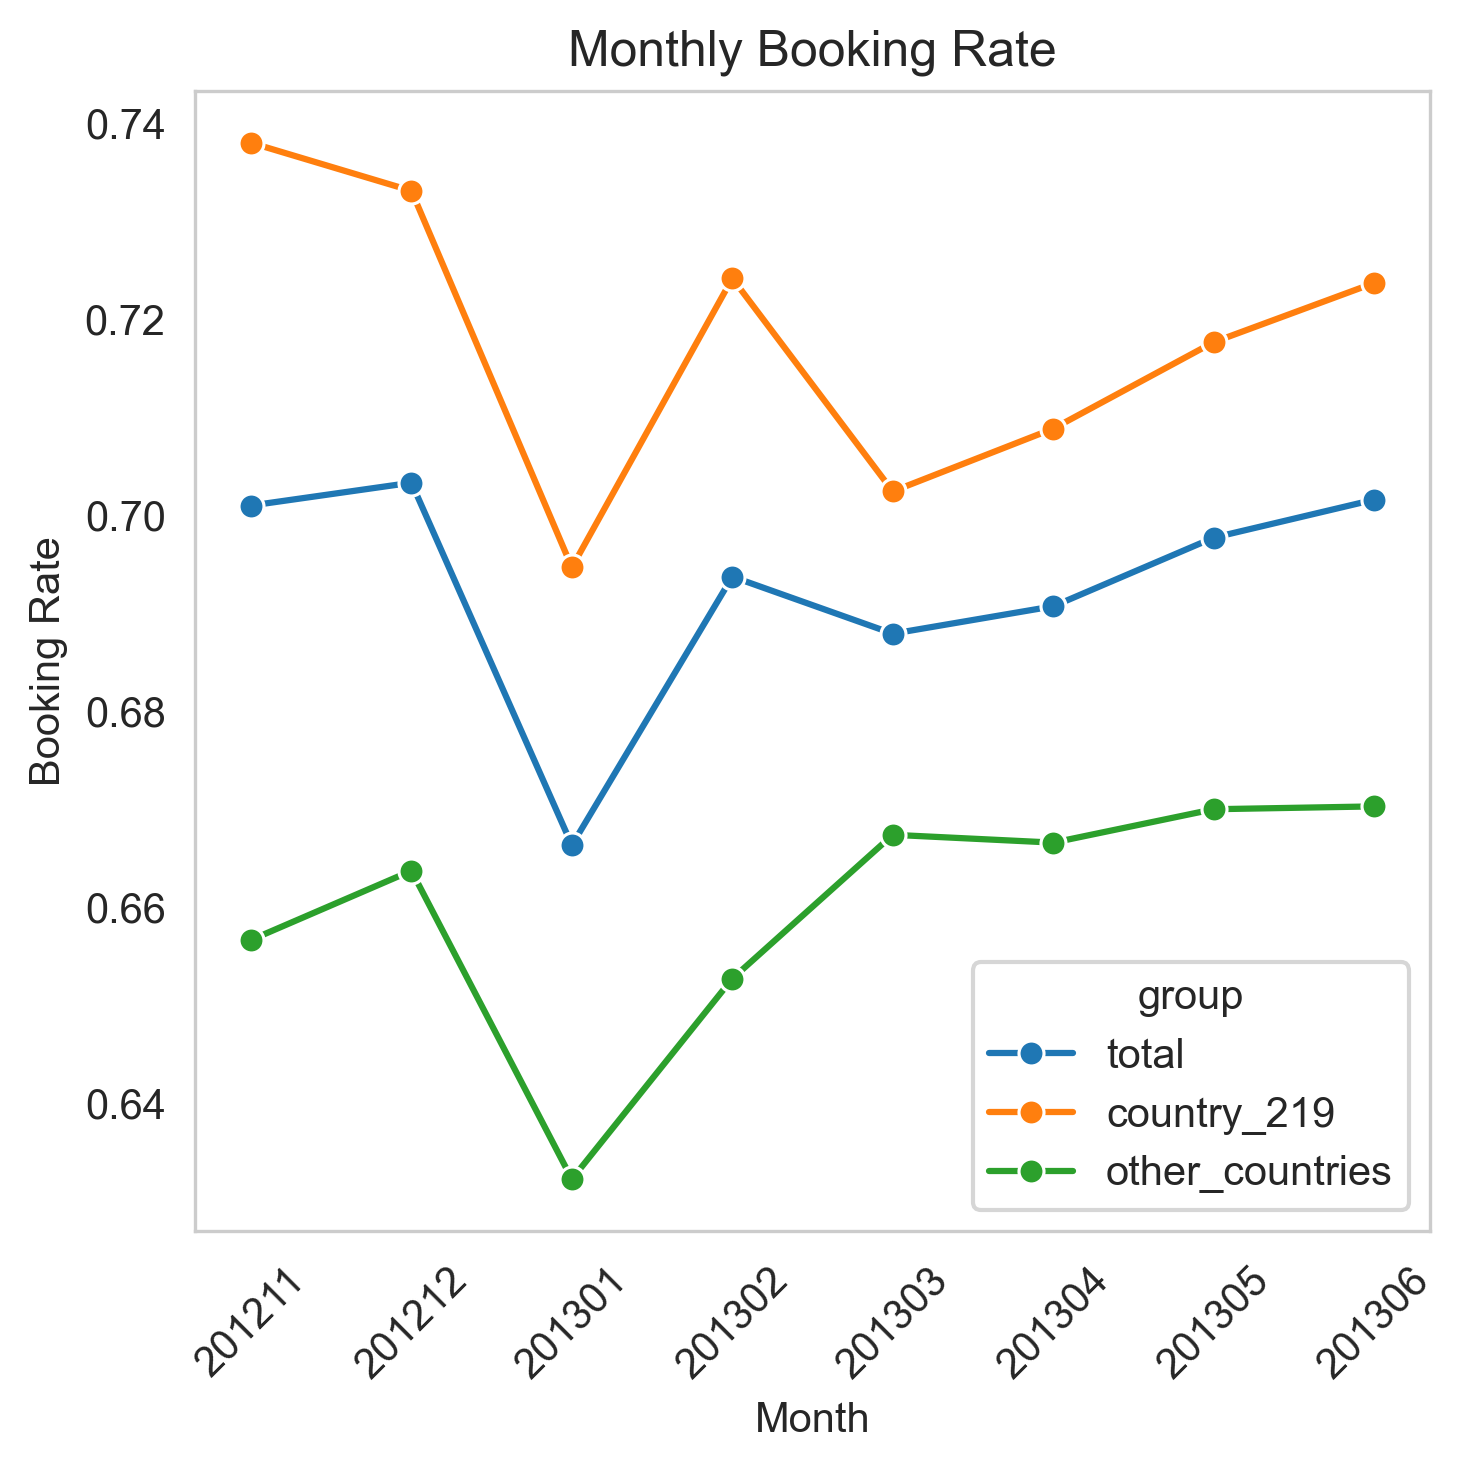

In [8]:
# The relationship between whether people will book a hotel depends on the month is affected by country_id=219
# https://ajourneyintodatascience.quora.com/Learning-to-Rank-Personalize-Expedia-Hotel-Searches-ICDM-2013-http-ajourneyintodatascience-ryin-main-quora-com-Le
# Let's verify this by plotting the booking rate over time and see if we can confirm this pattern

train_df = train_df.with_columns([
    # Let's see the overall pattern over linear time
    (pl.col("year").cast(pl.Utf8) + pl.col("month").cast(pl.Utf8).str.zfill(2)).alias("year_month"),
    pl.col("booking_bool").cast(pl.Int8)
])


def compute_booking_rate(df: pl.DataFrame, group_name: str) -> pl.DataFrame:
    return (
        df.group_by("year_month")
        .agg([
            pl.col("booking_bool").sum().alias("bookings"),
            pl.col("srch_id").n_unique().alias("searches")
        ])
        .with_columns([
            (pl.col("bookings") / pl.col("searches")).alias("booking_rate"),
            pl.lit(group_name).alias("group")
        ])
        .sort("year_month")
    )

# Compute booking rates and combine
total = compute_booking_rate(train_df, "total")
c219 = compute_booking_rate(train_df.filter(pl.col("visitor_location_country_id") == 219), "country_219")
others = compute_booking_rate(train_df.filter(pl.col("visitor_location_country_id") != 219), "other_countries")

df_plot = pl.concat([total, c219, others]).to_pandas()

# Plot
plt.figure(figsize=(5, 5), dpi=300)
sns.lineplot(data=df_plot, x="year_month", y="booking_rate", hue="group", marker="o")
plt.title("Monthly Booking Rate")
plt.xlabel("Month")
plt.ylabel("Booking Rate")
plt.xticks(rotation=45)
plt.grid(False)
plt.tight_layout()
plt.show()

In [9]:
# A clear cyclical pattern is present, so we transform our features to capture this better
# We will use sine and cosine transformations to encode cyclical features

def add_time_features(df: pl.DataFrame) -> pl.DataFrame:
    new_columns = []

    for col_name, period in [("month", 12), ("search_hour", 24), ("day_of_week", 7)]:
        new_columns.extend([
            pl.col(col_name).cast(pl.Float64).map_elements(
                lambda x: np.sin(2 * np.pi * x / period),
                return_dtype=pl.Float64
            ).alias(f"{col_name}_sin"),

            pl.col(col_name).cast(pl.Float64).map_elements(
                lambda x: np.cos(2 * np.pi * x / period),
                return_dtype=pl.Float64
            ).alias(f"{col_name}_cos")
        ])

    return df.with_columns(new_columns)


In [10]:
train_df = add_time_features(train_df)

In [11]:
### (1.2) Clean Search Columns
train_df.select(
    columns["search"]
).describe()

statistic,srch_id,date_time,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score
str,f64,str,f64,f64,f64,f64,f64,f64,f64,str
"""count""",4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,"""317406"""
"""null_count""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""4640941"""
"""mean""",166366.561096,null,14042.630393,2.385427,37.474165,1.972637,0.350492,1.110525,0.502213,null
"""std""",96112.230102,null,8111.843351,2.053243,51.993411,0.857063,0.732569,0.417229,0.499995,null
"""min""",1.0,"""2012-11-01 00:08:29""",2.0,1.0,0.0,1.0,0.0,1.0,0.0,"""-10.0001"""
"""25%""",82936.0,null,7101.0,1.0,4.0,2.0,0.0,1.0,0.0,null
"""50%""",166507.0,null,13541.0,2.0,17.0,2.0,0.0,1.0,1.0,null
"""75%""",249724.0,null,21084.0,3.0,48.0,2.0,0.0,1.0,1.0,null
"""max""",332785.0,"""2013-06-30 23:58:24""",28416.0,57.0,492.0,9.0,9.0,8.0,1.0,"""-99.9113"""


### (1.2) Clean Properties Columns

In [12]:
train_df.select(
    columns["booking"]
).describe()

statistic,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,click_bool,booking_bool
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4.958347e6,4.958347e6,4.958347e6,4.950983e6,4.958347e6,4.958347e6,3.867999e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6
"""null_count""",0.0,0.0,0.0,7364.0,0.0,0.0,1.090348e6,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",173.973897,70079.179496,3.180525,3.777777,0.634699,2.872589,0.130385,4.317913,16.856236,254.20959,0.21562,0.044749,0.027911
"""std""",68.345248,40609.920378,1.051024,1.050329,0.481514,1.531011,0.159463,1.834869,10.425655,16001.237061,0.411252,0.206751,0.164716
"""min""",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
"""25%""",100.0,35010.0,3.0,3.5,0.0,1.79,0.019,4.45,8.0,85.0,0.0,0.0,0.0
"""50%""",219.0,69638.0,3.0,4.0,1.0,2.77,0.069,4.91,16.0,122.0,0.0,0.0,0.0
"""75%""",219.0,105168.0,4.0,4.5,1.0,4.04,0.1805,5.31,26.0,184.96,0.0,0.0,0.0
"""max""",230.0,140821.0,5.0,5.0,1.0,6.98,1.0,6.21,40.0,1.9726328e7,1.0,1.0,1.0


In [13]:
# Prop_review_score is messy. So, we split the information into
train_df = train_df.with_columns([
    # Fill null with sentinel (-1), keep 0.0 as-is (means: no reviews)
    pl.col("prop_review_score").cast(pl.Float64).fill_null(-1.0).alias("prop_review_score_filled"),

    # Flag: is the score usable (non-null and > 0)?
    (pl.col("prop_review_score") > 0).cast(pl.Int8).alias("has_usable_review")
])



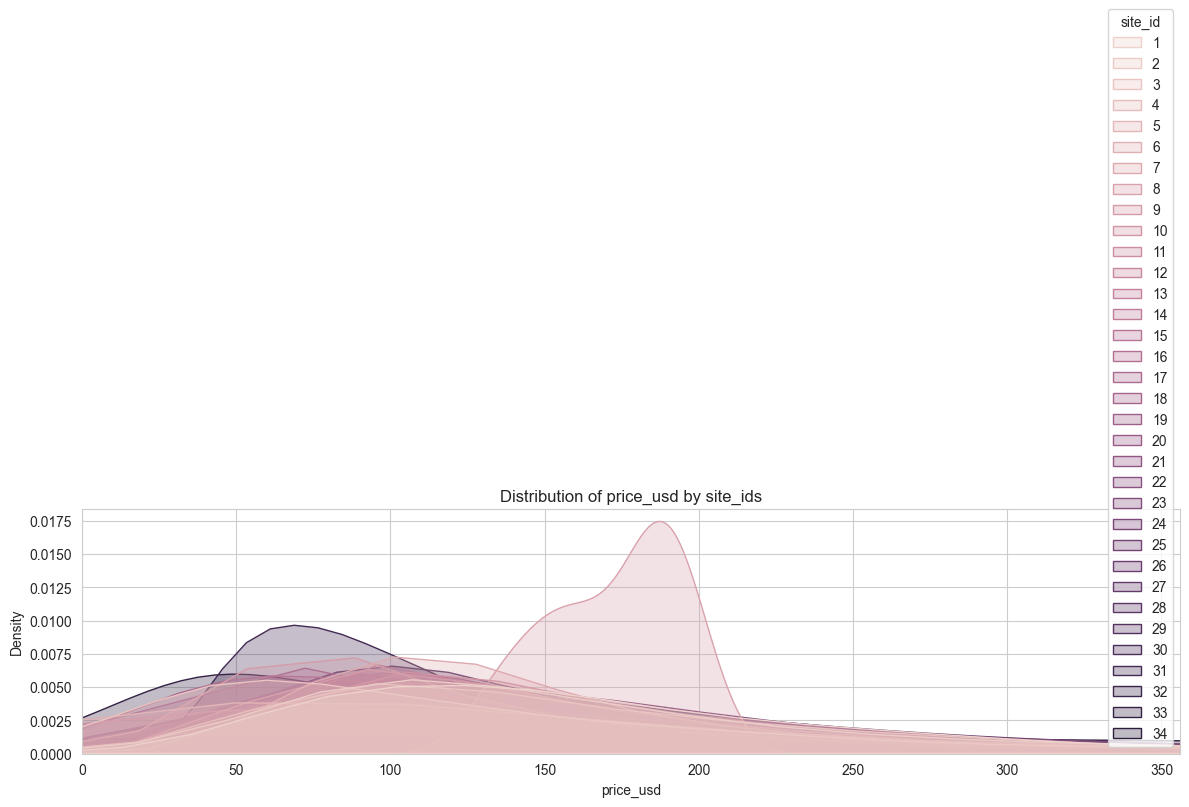

In [14]:
plt.figure(figsize=(12, 6))
sns.kdeplot(data=train_df, x="price_usd", hue="site_id", common_norm=False, fill=True, alpha=0.3)
plt.xlim(0, train_df["price_usd"].quantile(0.95))
plt.title("Distribution of price_usd by site_ids")
plt.xlabel("price_usd")
plt.ylabel("Density")
plt.tight_layout()
plt.show()

In [15]:
df_pd = train_df.select([
    "site_id", 
    "price_usd", 
    "srch_length_of_stay"
]).with_columns([
    (pl.col("price_usd") / pl.col("srch_length_of_stay")).alias("price_per_night")
]).to_pandas()
# Group and compute descriptive statistics
desc_table = (
    df_pd.groupby("site_id")
    .agg(
        price_mean=("price_per_night", "mean"),
        price_median=("price_per_night", "median"),
        price_q10=("price_per_night", lambda x: x.quantile(0.10)),
        price_q25=("price_per_night", lambda x: x.quantile(0.25)),
        price_q75=("price_per_night", lambda x: x.quantile(0.75)),
        price_q90=("price_per_night", lambda x: x.quantile(0.90)),
        price_q95=("price_per_night", lambda x: x.quantile(0.95)),
        price_q99=("price_per_night", lambda x: x.quantile(0.99)),
    )
    .reset_index()
)

# Optional: sort by price_mean
desc_table = desc_table.sort_values(by="price_median", ascending=False)

# Display or export
print(desc_table)

    site_id  price_mean  price_median  price_q10  price_q25   price_q75  \
7         8   85.983871     89.500000  71.000000  78.250000   94.500000   
6         7  101.434658     84.820000  29.566667  50.110000  128.637500   
13       14  122.910120     78.875000  25.110429  44.430000  125.040000   
14       15  308.494671     75.050000  21.803333  40.200000  126.140833   
29       30   98.481882     74.303333  19.975800  38.386667  120.110000   
4         5  153.428034     74.000000  25.000000  42.833333  119.000000   
10       11   93.683519     71.041667  21.713333  39.287667  120.110000   
26       27   96.278935     70.136667  18.831250  35.427500  128.282500   
22       23   92.237543     67.265833  17.958833  35.615833  123.136250   
31       32  159.972179     66.860000  18.533250  34.966167  122.630000   
20       21   93.139545     66.650000  17.041107  33.297750  113.988750   
1         2   88.582593     65.970000  20.501397  35.572917  107.874375   
23       24   88.816915  

In [16]:
def process_competitor_features(df: pl.DataFrame) -> pl.DataFrame:
    rate_cols = [f"comp{i}_rate" for i in range(1, 9)]
    inv_cols = [f"comp{i}_inv" for i in range(1, 9)]
    diff_cols = [f"comp{i}_rate_percent_diff" for i in range(1, 9)]

    # Cast and fill missing with 0
    for col in rate_cols + inv_cols + diff_cols:
        df = df.with_columns([
            pl.col(col).cast(pl.Float64).fill_null(0.0).alias(col)
        ])

    # Aggregation logic
    num_comps_lower = sum([pl.col(col) == 1 for col in rate_cols]).alias("num_comps_lower")
    num_comps_higher = sum([pl.col(col) == -1 for col in rate_cols]).alias("num_comps_higher")
    num_comps_with_inventory = sum([pl.col(col) == 1 for col in inv_cols]).alias("num_comps_with_inventory")

    # Mean of all percent diffs
    total_diff = reduce(lambda a, b: a + b, [pl.col(c) for c in diff_cols])
    count_diff = reduce(lambda a, b: a + b, [pl.col(c).is_not_null().cast(pl.Float64) for c in diff_cols])
    avg_diff = (total_diff / count_diff).alias("avg_comp_rate_percent_diff")

    # Mean when comp rate is lower
    lower_diffs = [
        pl.when(pl.col(r) == 1).then(pl.col(d)).otherwise(None)
        for r, d in zip(rate_cols, diff_cols)
    ]
    total_lower = reduce(lambda a, b: a + b, lower_diffs)
    count_lower = reduce(lambda a, b: a + b, [expr.is_not_null().cast(pl.Float64) for expr in lower_diffs])


    return df.with_columns([
        num_comps_lower,
        num_comps_higher,
        num_comps_with_inventory,
        avg_diff,   
    ])


def clean_competitor_columns(df: pl.DataFrame) -> pl.DataFrame:
    rate_cols = [f"comp{i}_rate" for i in range(1, 9)]
    inv_cols = [f"comp{i}_inv" for i in range(1, 9)]
    diff_cols = [f"comp{i}_rate_percent_diff" for i in range(1, 9)]
    all_comp_cols = rate_cols + inv_cols + diff_cols

    df = process_competitor_features(df)
    df = df.drop(all_comp_cols)

    return df


train_df = clean_competitor_columns(train_df)


In [17]:
train_df.describe()


statistic,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,parsed_date,year,month,day,search_hour,day_of_week,is_weekend_search,year_month,month_sin,month_cos,search_hour_sin,search_hour_cos,day_of_week_sin,day_of_week_cos,prop_review_score_filled,has_usable_review,num_comps_lower,num_comps_higher,num_comps_with_inventory,avg_comp_rate_percent_diff
str,f64,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4.958347e6,"""4958347""",4.958347e6,4.958347e6,"""251866""","""252988""",4.958347e6,4.958347e6,4.958347e6,4.950983e6,4.958347e6,4.958347e6,3.867999e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,"""317406""",3.350565e6,4.958347e6,4.958347e6,138390.0,4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.950983e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6
"""null_count""",0.0,"""0""",0.0,0.0,"""4706481""","""4705359""",0.0,0.0,0.0,7364.0,0.0,0.0,1.090348e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""4640941""",1.607782e6,0.0,0.0,4.819957e6,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,7364.0,0.0,0.0,0.0,0.0
"""mean""",166366.561096,null,9.953133,175.340453,null,null,173.973897,70079.179496,3.180525,3.777777,0.634699,2.872589,0.130385,4.317913,16.856236,254.20959,0.21562,14042.630393,2.385427,37.474165,1.972637,0.350492,1.110525,0.502213,null,1301.234406,0.2959,0.044749,386.283316,0.027911,"""2013-03-11 06:19:37.890843""",2012.803169,5.164621,15.662119,13.70044,3.824736,0.243891,null,-0.173963,-0.2448,0.010852,0.042348,0.055352,-0.043996,3.770681,0.952879,0.233776,0.19768,0.105543,2.833073
"""std""",96112.230102,null,7.64689,65.916249,null,null,68.345248,40609.920378,1.051024,1.050329,0.481514,1.531011,0.159463,1.834869,10.425655,16001.237061,0.411252,8111.843351,2.053243,51.993411,0.857063,0.732569,0.417229,0.499995,null,2023.951353,0.456446,0.206751,821.190577,0.164716,null,0.397603,3.492702,8.681805,5.41967,1.980819,0.429428,null,0.738481,0.603702,0.705909,0.706952,0.703843,0.706828,1.065553,0.211897,0.624802,0.613191,0.374386,164.411784
"""min""",1.0,"""2012-11-01 00:08:29""",1.0,1.0,"""1.41""","""0.0""",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,"""-10.0001""",0.01,0.0,0.0,0.0,0.0,"""2012-11-01 00:08:29""",2012.0,1.0,1.0,0.0,1.0,0.0,"""201211""",-0.974928,-0.900969,-0.974928,-0.900969,-0.974928,-0.900969,-1.0,0.0,0.0,0.0,0.0,0.0
"""25%""",82936.0,null,5.0,100.0,null,null,100.0,35010.0,3.0,3.5,0.0,1.79,0.019,4.45,8.0,85.0,0.0,7101.0,1.0,4.0,2.0,0.0,1.0,0.0,null,139.8,0.0,0.0,124.0,0.0,"""2013-01-14 17:47:32""",2013.0,3.0,8.0,10.0,2.0,0.0,null,-0.781831,-0.900969,-0.781831,-0.900969,-0.433884,-0.900969,3.5,1.0,0.0,0.0,0.0,0.0
"""50%""",166507.0,null,5.0,219.0,null,null,219.0,69638.0,3.0,4.0,1.0,2.77,0.069,4.91,16.0,122.0,0.0,13541.0,2.0,17.0,2.0,0.0,1.0,1.0,null,386.6,0.0,0.0,218.4,0.0,"""2013-03-13 20:13:18""",2013.0,4.0,16.0,14.0,4.0,0.0,null,-0.433884,-0.222521,-4.8986e-16,-0.222521,-2.4493e-16,-0.222521,4.0,1.0,0.0,0.0,0.0,0.0
"""75%""",249724.0,null,14.0,219.0,null,null,219.0,105168.0,4.0,4.5,1.0,4.04,0.1805,5.31,26.0,184.96,0.0,21084.0,3.0,48.0,2.0,0.0,1.0,1.0,null,1500.67,1.0,0.0,429.79,0.0,"""2013-05-10 00:01:38""",2013.0,6.0,23.0,18.0,5.0,

In [18]:
train_df = train_df.with_columns([
    pl.col("srch_query_affinity_score").cast(pl.Float64)
])

# 2. Compute a fill_value slightly worse than observed minimum
min_score = train_df.select(pl.col("srch_query_affinity_score").min()).item()
fill_value = min_score - 0.5

# 3. Fill missing values and create missing indicator
train_df = train_df.with_columns([
    pl.col("srch_query_affinity_score").fill_null(fill_value).alias("query_affinity_score_cleaned"),
    pl.col("srch_query_affinity_score").is_null().cast(pl.Int8).alias("query_affinity_missing")
])

In [19]:
train_df.describe()

statistic,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,click_bool,gross_bookings_usd,booking_bool,parsed_date,year,month,day,search_hour,day_of_week,is_weekend_search,year_month,month_sin,month_cos,search_hour_sin,search_hour_cos,day_of_week_sin,day_of_week_cos,prop_review_score_filled,has_usable_review,num_comps_lower,num_comps_higher,num_comps_with_inventory,avg_comp_rate_percent_diff,query_affinity_score_cleaned,query_affinity_missing
str,f64,str,f64,f64,str,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",4.958347e6,"""4958347""",4.958347e6,4.958347e6,"""251866""","""252988""",4.958347e6,4.958347e6,4.958347e6,4.950983e6,4.958347e6,4.958347e6,3.867999e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,317406.0,3.350565e6,4.958347e6,4.958347e6,138390.0,4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,"""4958347""",4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.950983e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6,4.958347e6
"""null_count""",0.0,"""0""",0.0,0.0,"""4706481""","""4705359""",0.0,0.0,0.0,7364.0,0.0,0.0,1.090348e6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.640941e6,1.607782e6,0.0,0.0,4.819957e6,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,"""0""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,7364.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",166366.561096,null,9.953133,175.340453,null,null,173.973897,70079.179496,3.180525,3.777777,0.634699,2.872589,0.130385,4.317913,16.856236,254.20959,0.21562,14042.630393,2.385427,37.474165,1.972637,0.350492,1.110525,0.502213,-24.146418,1301.234406,0.2959,0.044749,386.283316,0.027911,"""2013-03-11 06:19:37.890843""",2012.803169,5.164621,15.662119,13.70044,3.824736,0.243891,null,-0.173963,-0.2448,0.010852,0.042348,0.055352,-0.043996,3.770681,0.952879,0.233776,0.19768,0.105543,2.833073,-307.676165,0.935986
"""std""",96112.230102,null,7.64689,65.916249,null,null,68.345248,40609.920378,1.051024,1.050329,0.481514,1.531011,0.159463,1.834869,10.425655,16001.237061,0.411252,8111.843351,2.053243,51.993411,0.857063,0.732569,0.417229,0.499995,15.743238,2023.951353,0.456446,0.206751,821.190577,0.164716,null,0.397603,3.492702,8.681805,5.41967,1.980819,0.429428,null,0.738481,0.603702,0.705909,0.706952,0.703843,0.706828,1.065553,0.211897,0.624802,0.613191,0.374386,164.411784,74.255555,0.244779
"""min""",1.0,"""2012-11-01 00:08:29""",1.0,1.0,"""1.41""","""0.0""",1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,0.0,1.0,0.0,-326.5675,0.01,0.0,0.0,0.0,0.0,"""2012-11-01 00:08:29""",2012.0,1.0,1.0,0.0,1.0,0.0,"""201211""",-0.974928,-0.900969,-0.974928,-0.900969,-0.974928,-0.900969,-1.0,0.0,0.0,0.0,0.0,0.0,-327.0675,0.0
"""25%""",82936.0,null,5.0,100.0,null,null,100.0,35010.0,3.0,3.5,0.0,1.79,0.019,4.45,8.0,85.0,0.0,7101.0,1.0,4.0,2.0,0.0,1.0,0.0,-30.7748,139.8,0.0,0.0,124.0,0.0,"""2013-01-14 17:47:32""",2013.0,3.0,8.0,10.0,2.0,0.0,null,-0.781831,-0.900969,-0.781831,-0.900969,-0.433884,-0.900969,3.5,1.0,0.0,0.0,0.0,0.0,-327.0675,1.0
"""50%""",166507.0,null,5.0,219.0,null,null,219.0,69638.0,3.0,4.0,1.0,2.77,0.069,4.91,16.0,122.0,0.0,13541.0,2.0,17.0,2.0,0.0,1.0,1.0,-20.4513,386.6,0.0,0.0,218.4,0.0,"""2013-03-13 20:13:18""",2013.0,4.0,16.0,14.0,4.0,0.0,null,-0.433884,-0.222521,-4.8986e-16,-0.222521,-2.4493e-16,-0.222521,4.0,1.0,0.0,0.0,0.0,0.0,-327.0675,1.0
"""75%""",249724.0,null,14.0,219.0,null,nu

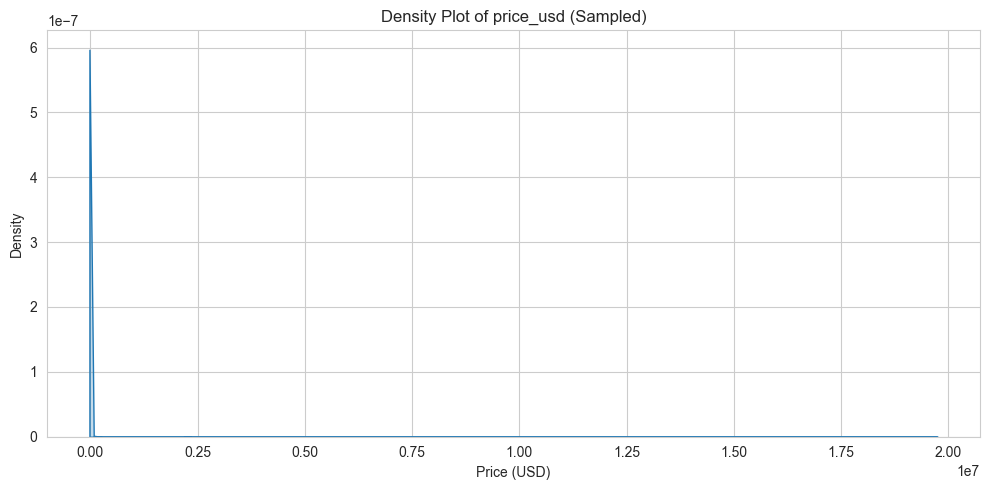

In [20]:
# Clean price
sampled_df = train_df.sample(n=100_000, with_replacement=False, shuffle=True)

plt.figure(figsize=(10, 5))
sns.kdeplot(sampled_df['price_usd'], fill=True)
plt.title("Density Plot of price_usd (Sampled)")
plt.xlabel("Price (USD)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()



In [30]:
import pandas as pd

# to easily reuse the code from Val's script to clean the price_usd column
train_data = train_df.to_pandas()

# verify that worked
print(train_data.head())

   srch_id            date_time  site_id  visitor_location_country_id  \
0        1  2013-04-04 08:32:15       12                          187   
1        1  2013-04-04 08:32:15       12                          187   
2        1  2013-04-04 08:32:15       12                          187   
3        1  2013-04-04 08:32:15       12                          187   
4        1  2013-04-04 08:32:15       12                          187   

  visitor_hist_starrating visitor_hist_adr_usd  prop_country_id  prop_id  \
0                    None                 None              219      893   
1                    None                 None              219    10404   
2                    None                 None              219    21315   
3                    None                 None              219    27348   
4                    None                 None              219    29604   

   prop_starrating  prop_review_score  ...  day_of_week_sin  day_of_week_cos  \
0                3      

In [31]:
# The gross price column in the training data will be used to determine which countries display price information per night or for the whole stay
test = train_data[['prop_country_id', 'prop_log_historical_price', 'price_usd', 'srch_length_of_stay', 'gross_bookings_usd']]
test = test[test['gross_bookings_usd'].notna()]  # only keep non-NaN observations

# adjusting the historical price
test['prop_historical_price'] = test['prop_log_historical_price'].replace(0, np.nan) # no meaningful comparison can be done
test['prop_historical_price'] = np.exp(test['prop_historical_price']).round(2) # converting to USD

# checking out some observations
print(test.head())

# The gross_booking_usd tends to be higher than the price_usd, due to taxes and other fees. For gross_bookings_usd observations that are significantly higher, that has to mean the price_usd is per night

# any cases where gross booking price is lower than price_usd?
print(test[test['gross_bookings_usd'] < test['price_usd']][['prop_country_id', 'prop_historical_price', 'price_usd', 'srch_length_of_stay', 'gross_bookings_usd']].head(50))

# any NaN values for either price_usd or gross_bookings_usd?
print(test[test['gross_bookings_usd'].isna() | test['price_usd'].isna()][['prop_country_id', 'prop_historical_price', 'price_usd', 'srch_length_of_stay', 'gross_bookings_usd']].head(50)) # empty dataframe

# any cases where gross booking price or the USD price is 0?
print(test[test['gross_bookings_usd'] == 0][['prop_country_id', 'prop_historical_price', 'price_usd', 'srch_length_of_stay', 'gross_bookings_usd']].head(50)) # not empty

# They are all cases where the price_usd is listed but the gross_bookings_usd is 0. For these I will assign them their price_usd value
test.loc[test['gross_bookings_usd'] == 0, 'gross_bookings_usd'] = test['price_usd']

# for cases where price_usd is equal to 0 (there are only 2), I assign the gross_bookings_usd price
test.loc[test['price_usd'] == 0, 'price_usd'] = test['gross_bookings_usd']

# In general the observations are slightly lower, I wonder if this is due to discounts or currency conversions. Calculating a ratio
test['gross_bookings_usd_ratio'] = (test['gross_bookings_usd'] / test['srch_length_of_stay']) / test['price_usd']

# ratio summary statistics
print(test['gross_bookings_usd_ratio'].describe())

# all observations with only one night are assigned a class value of 'one_night'
test['class'] = pd.Series(np.nan, index=test.index, dtype='object')
test.loc[test['srch_length_of_stay'] == 1, 'class'] = 'one_night'

# For cases where the USD price is higher than the gross price, and the number of nights specified is larger than 1, we assume price_usd is for the whole stay
test.loc[
    (test['price_usd'] > test['gross_bookings_usd']) &
    (test['srch_length_of_stay'] > 1),
    'class'
] = 'per_stay'

# Looking at cases with low ratios
print(test[test['gross_bookings_usd_ratio'] < 0.35][['prop_country_id', 'prop_historical_price', 'price_usd', 'srch_length_of_stay', 'gross_bookings_usd', 'class']].head(50))

# cases with high ratios
print(test[test['gross_bookings_usd_ratio'] > 1.5][['prop_country_id', 'prop_historical_price', 'price_usd', 'srch_length_of_stay', 'gross_bookings_usd', 'class']].head(50))

# cases with a ratio higher than 1.5 and where the number of nights specified is larger than 1 are assumed to have a class value of per_night
test.loc[
    (test['gross_bookings_usd_ratio'] > 1.3) &
    (test['srch_length_of_stay'] > 1),
    'class'
] = 'per_night'

# looking at observations with a ratio between 0.7 and 1.3
print(test[(test['gross_bookings_usd_ratio'] > 0.7) & (test['gross_bookings_usd_ratio'] < 1.3)][['prop_country_id', 'prop_historical_price', 'price_usd', 'srch_length_of_stay', 'gross_bookings_usd', 'class']].head(50))

# these observations will be made per night
test.loc[
    test['class'].isna() &
    (test['gross_bookings_usd_ratio'] > 0.7) &
    (test['gross_bookings_usd_ratio'] < 1.3),
    'class'
] = 'per_night'

# for observations where class is still NaN, srch_length_of_stay > 1, and the price is lower than the gross price, we assume the price is per stay
test.loc[
    test['class'].isna() &
    (test['srch_length_of_stay'] > 1) &
    (test['price_usd'] <= test['gross_bookings_usd']),
    'class'
] = 'per_stay'

# which observations are still NaN?
print(test[test['class'].isna()][['class', 'gross_bookings_usd_ratio', 'price_usd', 'srch_length_of_stay', 'gross_bookings_usd']].head(50)) # empty!

# Now I will aggregate the data by country ID and compute the percentages of class. First, all observations that are one_night are dropped.
filtered = test[test['class'] != 'one_night'].copy()
counts = filtered.groupby(['prop_country_id', 'class']).size().reset_index(name='count')
totals = counts.groupby('prop_country_id')['count'].transform('sum')
counts['percentage'] = counts['count'] / totals * 100
counts['percentage'] = counts['percentage'].round(2)
counts = counts.sort_values(by=['prop_country_id', 'percentage'], ascending=[True, False])
print(counts)

# are all the countries accounted for?
print(counts['prop_country_id'].nunique()) # 156
print(train_data['prop_country_id'].nunique()) # 172

# 16 countries are missing. They will be dealt with later, but for now I will create a dictionary with the class values for each country. Only the first class (the likeliest one) will be used
top_class_per_country = counts.drop_duplicates(subset='prop_country_id', keep='first')

     prop_country_id  prop_log_historical_price  price_usd  \
12               219                       4.44     100.89   
63               100                       0.00     145.00   
68               219                       4.62      85.00   
194              216                       4.54      47.94   
211              219                       4.44      42.00   

     srch_length_of_stay  gross_bookings_usd  prop_historical_price  
12                     1              114.29                  84.77  
63                     1              162.38                    NaN  
68                     1               96.41                 101.49  
194                    4              222.58                  93.69  
211                    1               47.10                  84.77  
       prop_country_id  prop_historical_price  price_usd  srch_length_of_stay  \
1503               219                    NaN     180.00                    1   
1753               219                 273.14

In [32]:
print(top_class_per_country.sort_values('percentage', ascending=True))

# The country with the smallest probability is at 75%. That is already really good. We can be confident then that the class values are correct. I will still use the price ratio method with the historical price to verify this

     prop_country_id      class  count  percentage
147              143  per_night      3       75.00
196              195  per_night      4       80.00
166              159  per_night     11       84.62
20                21  per_night      6       85.71
122              113  per_night     13       86.67
..               ...        ...    ...         ...
120              111  per_night      1      100.00
117              106  per_night     25      100.00
106               97  per_night     13      100.00
138              131  per_night      3      100.00
126              119  per_night     22      100.00

[156 rows x 4 columns]


In [33]:
# How many countries are not per night?
print(top_class_per_country[top_class_per_country['class'] != 'per_night']['prop_country_id'].nunique()) # 1 only

1


In [34]:
# One of the columns is the logged historical price over the last trading period, where a 0 is if it wasn't sold then. I will convert this to standard USD and create a column comparing that to the given price. However the price may be per night or for the whole stay, depending on the country. The srch_length_of_stay will be used to determine that.
train_data['prop_historical_price'] = train_data['prop_log_historical_price'].replace(0, np.nan) # no meaningful comparison can be done
train_data['prop_historical_price'] = np.exp(train_data['prop_historical_price']).round(2) # converting to USD

# In order to determine if the price is per night or the whole stay, I will divide the displayed price with the number of nights the user specified. This will be compared to the historical price in USD. If the value is significantly lower than the historical price, then the price is per night. If it is around the same, then the price is for the whole stay.
train_data['price_usd_per_night_test'] = train_data['price_usd'] / train_data['srch_length_of_stay']

# display adjustments
pd.set_option('display.max_columns', None)   # show all columns
pd.set_option('display.width', 1000)         # or set to a large number
pd.set_option('display.max_colwidth', None)  # avoid truncating long cell contents

# One of the variables is whether a hotel has a sales promotion currently displayed. That would affect the current price but not the historical price, and it would mean the current price is lower than it historically should be. I will use 25% for the adjustment, which is only for observations where the hotel has a sale

# Decreasing a price value by 25% means the decreased value has to be increased by 33% in order to get back to what it originally was
train_data['price_usd_without_promo'] = np.where(train_data['promotion_flag'] == 1, train_data['price_usd'] * 1.33, train_data['price_usd']).round(2)

# actually I think the historical_price column is already per night, or at least the description doesn't say anything about that. I will calculate a ratio between the two prices and see if it is significantly different than 1
train_data['price_ratio'] = train_data['price_usd_without_promo'] / train_data['prop_historical_price']

# looking at the ratio
print(train_data[['prop_historical_price', 'price_usd_without_promo', 'srch_length_of_stay', 'prop_country_id', 'price_ratio', 'promotion_flag']].head(50))

# displaying quantile statistics of the ratio
print(train_data['price_ratio'].describe())

# looking at the smallest values
print(train_data[train_data['price_ratio'] < 0.35][['prop_historical_price', 'price_usd_without_promo', 'srch_length_of_stay', 'prop_country_id', 'price_ratio', 'promotion_flag']].head(50))

    prop_historical_price  price_usd_without_promo  srch_length_of_stay  prop_country_id  price_ratio  promotion_flag
0                  141.17                   104.77                    1              219     0.742155               0
1                  152.93                   170.74                    1              219     1.116459               0
2                  137.00                   179.80                    1              219     1.312409               0
3                   80.64                   602.77                    1              219     7.474826               0
4                  138.38                   143.58                    1              219     1.037578               0
5                  181.27                   195.32                    1              219     1.077509               0
6                  122.73                   129.35                    1              219     1.053940               0
7                   62.80                    85.37      

In [35]:
# The adjusted USD price without promotion is significantly lower than the historical price. I will assume that means the price is per night. I will compare this assumption to the gross booking price country classifier
comp = pd.DataFrame(set(train_data[train_data['price_ratio'] < 0.35]['prop_country_id'])). \
    rename(columns={0:'prop_country_id'}). \
    merge(top_class_per_country[['prop_country_id', 'class']], on='prop_country_id', how='left')

# any cases where the class is not per_night?
print(comp[comp['class'] != 'per_night']) # 5

# Five countries have NaN values for the class. I already knew earlier that 16 countries are missing from the classifier. As every other country is per_night, then my assumption about the countries with low ratios being per night holds. As the USD price column is per night for these countries, no changes need to be made.

    prop_country_id class
11               19   NaN
25               38   NaN
52               79   NaN
57               89   NaN
69              108   NaN


In [36]:
# Checking out the other end of the spectrum
comp = pd.DataFrame(set(train_data[train_data['price_ratio'] > 2]['prop_country_id'])). \
    rename(columns={0:'prop_country_id'}). \
    merge(top_class_per_country[['prop_country_id', 'class']], on='prop_country_id', how='left')

print(train_data[train_data['price_ratio'] > 1.5][['prop_historical_price', 'price_usd_without_promo', 'srch_length_of_stay', 'prop_country_id', 'price_ratio', 'promotion_flag']].head(50))

# For cases where the ratio is significantly higher than the historical price, I will assume that means the price is for the whole stay. It will have to be adjusted to be per night. This is a mismatch with the results from earlier


      prop_historical_price  price_usd_without_promo  srch_length_of_stay  prop_country_id  price_ratio  promotion_flag
3                     80.64                   602.77                    1              219     7.474826               0
9                    172.43                   280.69                    1              219     1.627849               0
23                    84.77                   128.06                    1              219     1.510676               0
67                   165.67                   259.00                    1              219     1.563349               0
132                   61.56                   195.51                    2              158     3.175926               1
149                  175.91                   305.82                    4               31     1.738503               0
152                  206.44                   327.58                    4               31     1.586805               0
156                  152.93             

In [37]:
# Verifying the high ratio countries
high_ratio = train_data[train_data['price_ratio'] > 1.5].groupby('prop_country_id').size() / train_data.groupby('prop_country_id').size()
high_ratio.fillna(0, inplace=True)

# only keeping countries that have a high proportion of high ratios
high_ratio = high_ratio[high_ratio > 0.4]
print(high_ratio) # 2, only these countries have high ratios

# Print observations for these 2 countries
print(train_data[train_data['prop_country_id'].isin(high_ratio.index)][['prop_historical_price', 'price_usd_without_promo', 'srch_length_of_stay', 'prop_country_id', 'price_ratio', 'promotion_flag']].head(50))

# adjusting the values for the countries with a high ratio
train_data.loc[train_data['prop_country_id'].isin(high_ratio.index), 'price_usd_without_promo'] = train_data['price_usd_without_promo'] / train_data['srch_length_of_stay']


prop_country_id
126    0.428571
197    0.447368
dtype: float64
         prop_historical_price  price_usd_without_promo  srch_length_of_stay  prop_country_id  price_ratio  promotion_flag
73183                   497.70                   630.00                    4              197     1.265823               0
73184                   497.70                   656.00                    4              197     1.318063               0
73185                   497.70                  1078.00                    4              197     2.165963               0
73186                   497.70                   797.00                    4              197     1.601366               0
73187                      NaN                  2701.00                    4              197          NaN               0
73188                   497.70                   736.00                    4              197     1.478802               0
73189                   497.70                   979.00                    4

In [38]:
# What is the average price per night for countries? Computing a weighted average between current price and nights
weighted_avg = (
    train_data
    .assign(weighted_price=lambda df: df['price_usd_without_promo'] * df['srch_length_of_stay'])
    .groupby('prop_country_id')
    .agg(
        total_weighted_price=('weighted_price', 'sum'),
        total_stay=('srch_length_of_stay', 'sum')
    )
    .assign(weighted_avg_price_usd_without_promo=lambda df: df['total_weighted_price'] / df['total_stay'])
    .round(2)
    .reset_index()[['prop_country_id', 'weighted_avg_price_usd_without_promo']]
)

print(weighted_avg)

# quantile statistics
print(weighted_avg['weighted_avg_price_usd_without_promo'].describe())

# looking at the most expensive countries
print(weighted_avg[weighted_avg['weighted_avg_price_usd_without_promo'] > 1000][['prop_country_id', 'weighted_avg_price_usd_without_promo']])

     prop_country_id  weighted_avg_price_usd_without_promo
0                  1                                223.43
1                  2                                137.58
2                  4                                149.63
3                  7                                132.99
4                  9                                131.30
..               ...                                   ...
167              224                                 87.92
168              225                                387.06
169              226                                166.79
170              229                                101.32
171              230                                246.43

[172 rows x 2 columns]
count     172.000000
mean      309.350000
std       610.837121
min        32.740000
25%       137.302500
50%       183.685000
75%       260.750000
max      5426.590000
Name: weighted_avg_price_usd_without_promo, dtype: float64
     prop_country_id  weighted_avg_price_

In [39]:
train_data[train_data['prop_country_id'].isin([53, 39, 34])][['prop_historical_price', 'price_usd_without_promo', 'srch_length_of_stay', 'prop_country_id', 'price_ratio', 'promotion_flag']]. \
    sort_values(by=['price_usd_without_promo', 'prop_country_id'], ascending = False)

,prop_historical_price,price_usd_without_promo,srch_length_of_stay,prop_country_id,price_ratio,promotion_flag
1168566,NaN,19726328.00,4,39,NaN,0
3117007,160.77,9381308.71,1,53,58352.358711,0
1168574,NaN,5444467.00,4,39,NaN,0
1168581,NaN,5194731.29,4,39,NaN,1
1168576,NaN,4884239.00,4,39,NaN,0
...,...,...,...,...,...,...
3402025,86.49,0.01,1,39,0.000116,0
3402026,68.03,0.01,1,39,0.000147,1
3402029,74.44,0.01,1,39,0.000134,0
3402030,75.94,0.01,1,39,0.000132,0


In [40]:
# A lot of these values are extremely high and unrealistic. I will make adjustments to observations that have a price higher than 1000. For ones that have the historical value, I will use that instead. Otherwise for NaNs I do current price / nights

# This is needed for the where condition so that only these rows are affected by the calculation
mask = train_data['price_usd_without_promo'] > 1000

# doing the calculation
train_data.loc[mask, 'price_usd_without_promo'] = np.where(
    train_data.loc[mask, 'prop_historical_price'].notna(),
    train_data.loc[mask, 'prop_historical_price'],
    train_data.loc[mask, 'price_usd_without_promo'] / train_data.loc[mask, 'srch_length_of_stay']
)

In [41]:
# What is the average price per night for countries? Computing a weighted average between current price and nights
weighted_avg = (
    train_data
    .assign(weighted_price=lambda df: df['price_usd_without_promo'] * df['srch_length_of_stay'])
    .groupby('prop_country_id')
    .agg(
        total_weighted_price=('weighted_price', 'sum'),
        total_stay=('srch_length_of_stay', 'sum')
    )
    .assign(weighted_avg_price_usd_without_promo=lambda df: df['total_weighted_price'] / df['total_stay'])
    .round(2)
    .reset_index()[['prop_country_id', 'weighted_avg_price_usd_without_promo']]
)

print(weighted_avg)

# quantile statistics
print(weighted_avg['weighted_avg_price_usd_without_promo'].describe()) # much much better than before

     prop_country_id  weighted_avg_price_usd_without_promo
0                  1                                223.43
1                  2                                137.58
2                  4                                149.53
3                  7                                132.99
4                  9                                130.96
..               ...                                   ...
167              224                                 85.82
168              225                                150.34
169              226                                166.79
170              229                                101.32
171              230                                241.12

[172 rows x 2 columns]
count     172.000000
mean      197.838140
std       129.457518
min        32.740000
25%       132.937500
50%       167.475000
75%       225.297500
max      1468.740000
Name: weighted_avg_price_usd_without_promo, dtype: float64


In [42]:
# Do any hotels have NaN price values?
print(train_data[train_data['price_usd_without_promo'].isna()][['prop_historical_price', 'price_usd_without_promo', 'srch_length_of_stay', 'prop_country_id', 'price_ratio', 'promotion_flag']].head(50)) # empty dataframe

Empty DataFrame
Columns: [prop_historical_price, price_usd_without_promo, srch_length_of_stay, prop_country_id, price_ratio, promotion_flag]
Index: []


In [43]:
# convert the pandas dataframe back to polars
pl_df = pl.from_pandas(train_data)

# Save Polars DataFrame to a CSV file
pl_df.write_csv('cleaned_training_data.csv')

In [45]:
import os
os.getcwd()

'/Users/valentindonchev/Library/CloudStorage/OneDrive-VrijeUniversiteitAmsterdam/Data Mining/DataMiningTechniques/Group Assignment 2/Group Assignmnet 2'